# Plan
## This notebook
1. Super-quick intro into BaBar DIRC subdetector
2. You create a WGAP-GP GAN

___Congradulations on making it to level two of the seminar!___

Here is a bonus: a relaxing link to play with advanced GANs without writing code:
* https://affinelayer.com/pixsrv/

# BaBar DIRC
![DIRC scheme](https://www.slac.stanford.edu/BFROOT/www/Detector/DIRC/Gifs/NewDirc.gif)

Detection of Internally Reflected Cherenkov light - a particle identification detector in other words. Unlike the calorimeter competition, we will only generate high-level observables (particle delta log-likelihoods (DLL)) that are obtained after the reconstruction.

We want the generation to be conditional on full kinematics of event: energy, pseudorapidity and the distance between the particle track and DIRC bar side of signal particle. For the data-driven GAN this is just 11-D tabular data.

Data was generated with [FastDIRC](https://github.com/jmhardin/FastDIRC) modified to simulate two particle-events.

### Task 1 (difficulty: a couple of years ago this would have been a [paper](https://www.sciencedirect.com/science/article/pii/S0168900219300701) in a good journal, now should be doable in 10-40 minutes*)
\* after Denis Derkach formulated the problem and I did all the dirty work of getting training data

Create a conditional Jensen-Shannon GAN to generate Y given X

### Task 2 (difficulty: ~5 lines of code after completing task 1)

Create a conditional classical Wasserstein GAN wth gradient penalty to generate Y given X

__Note__: Task 2 is easier to code and train than task 1. On the other hand, you have an example for JS GAN

# Das Kode

In [0]:
import requests
import re

URL_RE = r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+"
url_scrabber = re.compile(r'\s*<input type="hidden" name="downloadURL" '
                          'value="(?P<download_url>' + URL_RE + ')" '
                          'id="downloadURL">')

def get_cernbox_direct_link(url):
  guard_page = requests.get(url)
  for line in guard_page.text.split('\n'):
      match = url_scrabber.match(line)
      if match:
        return match.group('download_url')
  raise RuntimeError("downloadURL not found. Most likely case is a change in CERNBox")

In [0]:
data_url = get_cernbox_direct_link("https://cernbox.cern.ch/index.php/s/hWCh4umYQ0KShjW")
DATA_FILE_NAME = './kaons.hdf'

In [114]:
! wget "$data_url" -O "$DATA_FILE_NAME" -nc

File ‘./kaons.hdf’ already there; not retrieving.


In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [116]:
data = pd.read_hdf(DATA_FILE_NAME)
data.head()

,dll_electron,dll_kaon,dll_muon,dll_proton,dll_bt,particle_one_energy,particle_two_energy,particle_one_eta,particle_two_eta,particle_one_x,particle_two_x
48609366,-0.212708,2.314453,0.404724,-8.901489,-395.625427,5.761642,7.775553,-0.101042,-1.170546,4.806355,11.518691
85800802,-0.975586,7.093811,-0.254272,-118.109131,-125.633118,2.952495,4.515579,-1.027812,1.425283,8.347982,12.483961
48063890,1.210968,1.983414,-0.938339,-3.278305,-201.828049,5.667168,6.883764,0.243560,0.688672,9.765896,1.966456
6662551,-0.033142,1.237122,0.060791,0.109146,-196.228241,6.988772,4.271856,-1.019691,-0.693035,14.185906,15.605581
89492993,0.239120,3.052887,-0.522217,-22.034760,-268.287598,5.403506,8.019310,0.975898,1.015718,6.350332,4.286400


In [0]:
X_COLUMNS = ["particle_one_energy",
             "particle_two_energy",
             "particle_one_eta",
             "particle_two_eta",
             "particle_one_x",
             "particle_two_x"]
Y_COLUMNS = ["dll_electron",
             "dll_kaon",
             "dll_muon",
             "dll_proton",
             "dll_bt"]
assert Y_COLUMNS + X_COLUMNS == list(data.columns)

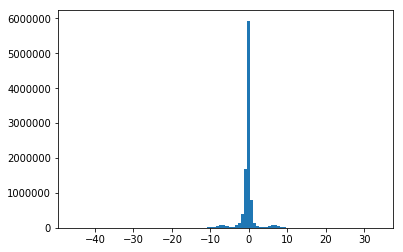

In [118]:
# If feel physically inclined, feel free to make a hundred of plots.
# However, for purposes of this exercise, abstract tabular X, Y will suffice.
# In order to achive this wonderful state, the data needs to be normalized.
# Please use the sklearn.preprocessing.QuantileTransformer to transform each feature
# into a Gaussian
plt.hist(data.values[:, 0], bins=100);

In [0]:
### SOLUTION!!! ###
# Will take a couple of minutes
from sklearn.preprocessing import QuantileTransformer
scaler = QuantileTransformer(output_distribution="normal")
data_transformed = scaler.fit_transform(data.values).astype(np.float32)

After the transformation, features should look like this:
![feature after normalization](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/gauss.png)

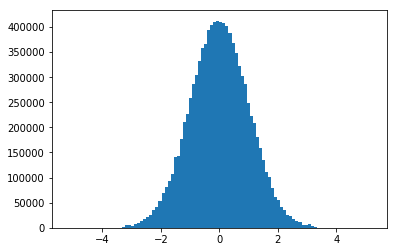

In [120]:
plt.hist(data_transformed[:, 0], bins=100);

In [0]:
train, test = train_test_split(data_transformed, test_size=0.1)

In [0]:
LATENT_DIM = 64

Please create a fully-connected generator. Remember, we need a conditional GAN, so the generator input should have dimensions for X and noise; output - for Y.

You can start with a small one, make sure the code works, then add more layers.

In [0]:
# Note that WGAN does not work well with ELU (as per my experience and the original paper)
### SOLUTION !!! ###
gen = nn.Sequential(nn.Linear(LATENT_DIM + len(X_COLUMNS), 64), nn.LeakyReLU(),
                    nn.Linear(64, 64), nn.LeakyReLU(),
                    nn.Linear(64, 64), nn.LeakyReLU(),
                    nn.Linear(64, len(Y_COLUMNS))).cuda()
gen_opt = torch.optim.RMSprop(gen.parameters(), lr=1e-2)
gen_scheduler = torch.optim.lr_scheduler.MultiStepLR(gen_opt, milestones=[10000, 30000], gamma=0.1)

In [0]:
assert gen[0].in_features == LATENT_DIM + len(X_COLUMNS)
assert gen[-1].out_features == len(Y_COLUMNS)

Please create a fully-connected discriminator

In [0]:
### SOLUTION !!! ###
disc = nn.Sequential(nn.Linear(data.shape[1], 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 64), nn.LeakyReLU(),
                     nn.Linear(64, 1)).cuda()

assert disc[0].in_features == data.shape[1]
assert disc[-1].out_features == 1

disc_opt = torch.optim.RMSprop(disc.parameters(), lr=1e-2)
disc_scheduler = torch.optim.lr_scheduler.MultiStepLR(disc_opt, milestones=[10000, 30000], gamma=0.1)

In [0]:
TRAIN_BATCH_SIZE = 1024
def sample_real_data(batch_size):
  """
  Inifintly repeats and shuffles the train dataset, outputs the
  result in delicious batches.
  """
  while True:
    dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                             shuffle=True, drop_last=True)
    for batch in dataloader:
      yield batch
infinite_data = sample_real_data(TRAIN_BATCH_SIZE)

Write a function that would sample the generator for given X. The function should return a GPU-based tensor.

`concatenate(generator(concatenate(noise, x)), x)`

In [0]:
### SOLUTION !!! ###
def sample_gen_data(x):
  noise = torch.randn(x.shape[0], LATENT_DIM, dtype=torch.float32, device="cuda")
  return torch.cat((gen(torch.cat((noise, x), dim=1)), x), dim=1)

In [0]:
test_sample = sample_gen_data(torch.from_numpy(train[:3, len(Y_COLUMNS):]).cuda())
assert test_sample.shape == (3, data.shape[1])

In [0]:
# https://github.com/caogang/wgan-gp/blob/master/gan_mnist.py
def calc_gradient_penalty_classic(critic:torch.nn.Module,
                                  real_data:torch.Tensor,
                                  fake_data:torch.Tensor):
  """
  Computes Gradient Penalty in random interpolates, in its classic form:
  (|∇(D(x)|^2 - 1)^2, x is interpolated between a real and a generated sample
  Args:
    critic: a torch model whose gradient needs to be penalised
    real_data[batch_size, n_features]: a sample of real data
    fakse_data[batch_size, n_features]: a sample of fake data
  Returns:
    torch.Tensor, scalar, gradient penalty evalute
  """
  assert real_data.shape == fake_data.shape
  alpha = torch.rand(real_data.shape[0], 1)
  alpha = alpha.expand(real_data.size()).cuda()

  interpolates = (alpha * real_data + ((1 - alpha) * fake_data)).cuda()
  interpolates = torch.autograd.Variable(interpolates, requires_grad=True)

  disc_interpolates = critic(interpolates)

  gradients = torch.autograd.grad(
      outputs=disc_interpolates, inputs=interpolates,
      grad_outputs=torch.ones(disc_interpolates.size(), device="cuda"),
      create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
  return gradient_penalty

In [0]:
### SOULTION !!! ###
# https://arxiv.org/pdf/1801.04406.pdf
# Doesn't go well with Wassershtein GANs
def calc_gradient_penalty_zero_based(critic:torch.nn.Module,
                                     points:torch.Tensor):
  """
  Computes Gradient Penalty in given points:
  |∇(D(x))|^2
  Args:
    critic: a torch model whose gradient needs to be penalised
    points[batch_size, n_features]: points where to compute the penalty
  Returns:
    torch.Tensor, scalar, gradient penalty evalute
  """
  points_var = torch.autograd.Variable(points, requires_grad=True)
  gradients = torch.autograd.grad(
      outputs=critic(points_var), inputs=points_var,
      grad_outputs=torch.ones(points_var.size(), device="cuda"),
      create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = gradients.norm(2, dim=1).mean()
  return gradient_penalty

In [0]:
LAMBDA = 1.
### SOLUTION !!! ###
def train_disc(gan_type="WGAN-GP"):
    """
    Trains the discriminator for one step. Please note
    this is not a pure function, it captutes the majority of variables
    from the context.
    """
    real_data = next(infinite_data).to("cuda")
    x_gen = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    gen_data = sample_gen_data(x_gen)
    
    if gan_type == "JS":
      logp_real_is_real = F.logsigmoid(disc(real_data))
      logp_gen_is_fake = F.logsigmoid(-disc(gen_data))
      disc_loss = -logp_real_is_real.mean() - logp_gen_is_fake.mean()
    elif gan_type == "WGAN-GP":
      disc_loss = disc(real_data).mean() - disc(gen_data).mean() + \
                  calc_gradient_penalty_classic(disc, real_data, gen_data)*LAMBDA
    else:
      raise ValueError("Unknown GAN type. Valid ones are: JS, WGAN-GP")
    
    disc_opt.zero_grad()
    disc_loss.backward()
    disc_opt.step()
    return disc_loss

In [0]:
### SOLUTION !!! ###
def train_gen(gan_type="WGAN-GP"):
    """Trains generator for one step"""
    real_data_x = next(infinite_data)[:, len(Y_COLUMNS):].to("cuda")
    
    gen_data = sample_gen_data(real_data_x)
    
    if gan_type == "JS":
      logp_gen_is_real = F.logsigmoid(disc(gen_data))
      gen_loss = -logp_gen_is_real.mean()
    elif gan_type == "WGAN-GP":
      gen_loss = disc(gen_data).mean()
    
    gen_opt.zero_grad()
    gen_loss.backward()
    gen_opt.step()
    return gen_loss

In [0]:
import os
from torch.utils.tensorboard import SummaryWriter
TENSORBOARD_LOGDIR = "./logs"
MODEL_NAME = "DIRCv16"
summary_writer = SummaryWriter(log_dir=os.path.join(TENSORBOARD_LOGDIR, MODEL_NAME))

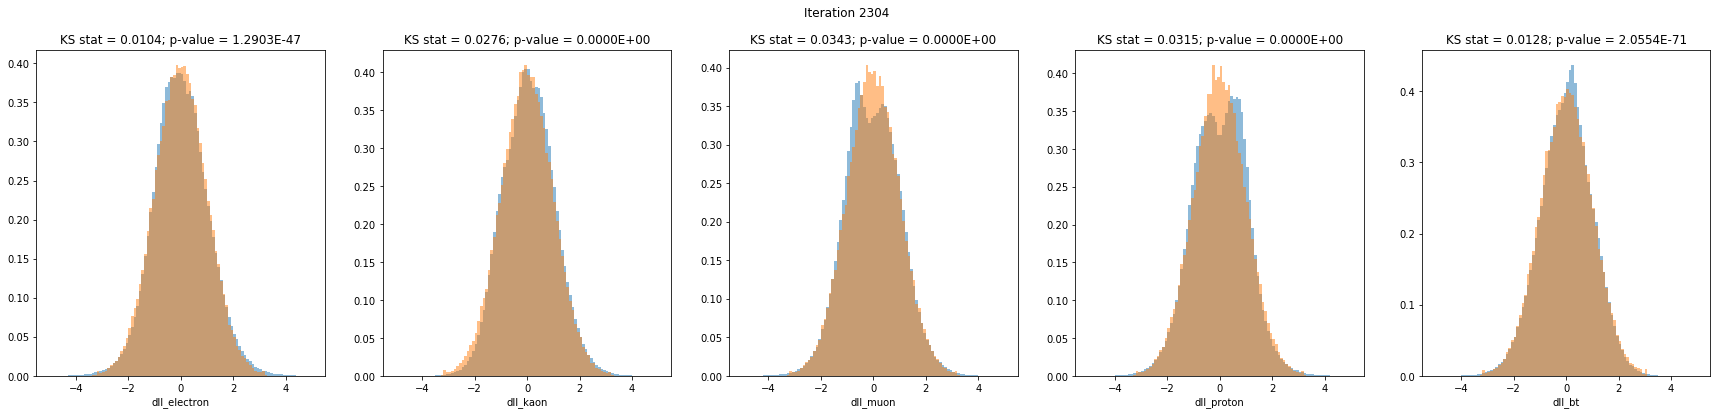

In [0]:
DISCRIMINATOR_ITERATIONS_PER_GENEREATOR = 5
VALIDATION_INTERVAL = 256
HIST_BINS=100
DATA_HIST_RANGE=[-5, 5]

data_linspace_np = np.linspace(0, 10, num=256, dtype=np.float32)
data_linspace_torch = torch.from_numpy(data_linspace_np)[:, None].cuda()
validation_data = torch.from_numpy(test).cuda()
validation_data_np = test
validation_x = validation_data[:, len(Y_COLUMNS):]

for i in range(100000):
    gen_scheduler.step()
    disc_scheduler.step()
    for _ in range(DISCRIMINATOR_ITERATIONS_PER_GENEREATOR):
        disc_loss_this_iter = train_disc()
    
    gen_loss_this_iter = train_gen()
    summary_writer.add_scalar("discriminator loss", disc_loss_this_iter,
                              global_step=i)
    summary_writer.add_scalar("generator loss", gen_loss_this_iter,
                              global_step=i)
    if i % VALIDATION_INTERVAL == 0:
        clear_output(True)        
        validation_generated = sample_gen_data(validation_x)
        validation_generated_np = validation_generated.data.cpu().numpy()
        
        fig, axes_list = plt.subplots(ncols=5, figsize=[6*len(Y_COLUMNS), 6])
        for index, ax in enumerate(axes_list):
          ax.hist(validation_generated_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Generated', bins=HIST_BINS)
          ax.hist(validation_data_np[:, index], range=DATA_HIST_RANGE,
                  alpha=0.5, density=True, label='Real', bins=HIST_BINS)
          ax.set_xlabel(data.columns[index])
          ks_result = ks_2samp(validation_generated_np[:, index],
                                    validation_data_np[:, index])
          ax.set_title("KS stat = {:.4f}; p-value = {:.4E}".format(*tuple(ks_result)))
        fig.suptitle("Iteration {}".format(i))
        plt.show()

After a little bit of training, the plots should look like this: ![semitrained GAN](https://github.com/yandexdataschool/mlhep2019/raw/master/notebooks/day-6/semi-trained.png)

If you want to push precision to the limit, you want to increase batch size and reduce learning rate over time. You'll also need to monitor the validation losses to avoid overfitting.

P. S.

It is tempting to ask you to get KS p-value to, say, 0.5. But kind of pointless. The ability of a KS test to distingush two samples depends on the test size. And I have 19822705 examples (they are quite cheap to generate). By the time a model reaches that quality, the error is dominated by the systematic uncertainty caused by the fact that we only use so many parametes to describe an actually very complex relationship.

P. P. S.

As you know from Artem's lecture, this plot does not comprehensively describe the quality of the GAN. Please feel free to add better quality measures.